In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Data preparation

## CSL air quality data

In [5]:
csl_data = pd.read_csv("data/csl_data.csv")
csl_data['timestamp'] = pd.to_datetime(csl_data['timestamp'],unit='s')
csl_data = csl_data.drop(['minute', 'hour', 'day', 'month','year'], axis=1) #wrong timezone (BST)
data_cols = [col for col in csl_data.columns if 'AQI' not in col]
csl_data = csl_data[data_cols] #drop columns relating to AQI

#date and time in GMT timezone
csl_data['month'] = csl_data.timestamp.dt.month
csl_data['day'] = csl_data.timestamp.dt.day
csl_data['hour'] = csl_data.timestamp.dt.hour+1 #+1 for hour ending
csl_data['year'] = csl_data.timestamp.dt.year
#group data by date+time to calculate hourly averages
csl_data = csl_data.groupby(['year', 'month', 'day', 'hour']).mean()
csl_data.reset_index(inplace=True)
csl_data['timestamp'] = pd.to_datetime(csl_data[['year', 'month', 'day', 'hour']])
csl_data = csl_data.set_index('timestamp')
csl_data.tail()

,year,month,day,hour,CH4,CO,NH3,NO2,PM1_0,PM2_5,PM10_0,eCO2,tVOC,vcc_volt
timestamp,,,,,,,,,,,,,,
2021-01-14 16:00:00,2021,1,14,16,0.0,0.0325,0.0,0.010791,0.00,0.00,0.00,1120.25,109.25,3.33400
2021-01-14 17:00:00,2021,1,14,17,0.0,0.0225,0.0,0.016928,0.00,0.00,0.00,987.25,88.75,3.29250
2021-01-14 18:00:00,2021,1,14,18,0.0,0.0200,0.0,0.022409,0.00,0.00,0.00,674.00,41.50,3.24950
2021-01-14 19:00:00,2021,1,14,19,0.0,0.0125,0.0,0.031883,0.00,0.00,0.25,447.00,6.75,3.13425
2021-01-14 20:00:00,2021,1,14,20,0.0,0.0100,0.0,0.039225,0.25,0.25,0.25,464.50,9.50,3.03900


## City centre weather data

In [8]:
from datetime import timedelta

centre_data = pd.read_csv("data/cardiff_centre_data.csv")
data_cols = ['Date', 'Time', 'Modelled Wind Direction', 'Modelled Wind Speed', 'Modelled Temperature']
centre_data = centre_data[data_cols]
centre_data = centre_data.drop(centre_data.shape[0]-1) #drop last row, which is invalid
centre_data['Date'] = pd.to_datetime(centre_data['Date'])
def fix_centre_dates(row):
    if row.Time == '24:00:00':
        row.Time = '00:00:00'
        row.Date = row.Date + timedelta(days=1)
    return row
centre_data = centre_data.apply(fix_centre_dates, axis=1)
centre_data['Date'] = pd.to_datetime(centre_data['Date'].apply(lambda d: d.strftime('%Y-%m-%d'))+' '+centre_data['Time'])
centre_data = centre_data.drop(['Time'], axis=1)
centre_data.columns = ['Date', 'Wind_dir', 'Wind_spd', 'Temperature']
centre_data = centre_data.set_index('Date')
centre_data[centre_data.columns] = centre_data[centre_data.columns].apply(pd.to_numeric, errors='coerce')
centre_data.head()

,Wind_dir,Wind_spd,Temperature
Date,,,
2020-06-23 01:00:00,210.0,2.7,10.7
2020-06-23 02:00:00,199.5,2.8,10.3
2020-06-23 03:00:00,209.8,3.4,10.7
2020-06-23 04:00:00,215.0,2.6,10.9
2020-06-23 05:00:00,195.7,1.9,10.8


## Merging the two datasets

In [9]:
full_data = csl_data.join(centre_data)
full_data = full_data.dropna()

full_data.head()

,year,month,day,hour,CH4,CO,NH3,NO2,PM1_0,PM2_5,PM10_0,eCO2,tVOC,vcc_volt,Wind_dir,Wind_spd,Temperature
timestamp,,,,,,,,,,,,,,,,,
2020-06-23 12:00:00,2020,6,23,12,0.0,0.075000,0.005,0.001414,0.50,4.000000,5.000000,706.000000,46.00,3.369000,158.2,3.3,19.4
2020-06-23 13:00:00,2020,6,23,13,0.0,0.076667,0.010,0.001275,2.00,2.666667,3.333333,877.333333,72.00,3.365667,168.3,3.9,21.4
2020-06-23 14:00:00,2020,6,23,14,0.0,0.090000,0.010,0.000936,2.50,3.500000,4.000000,1803.000000,213.50,3.366500,169.8,4.8,22.0
2020-06-23 15:00:00,2020,6,23,15,0.0,0.110000,0.010,0.000719,1.50,2.000000,2.250000,2311.500000,290.75,3.364000,171.5,5.4,22.0
2020-06-23 16:00:00,2020,6,23,16,0.0,0.100000,0.010,0.000921,1.25,3.250000,6.250000,1907.750000,229.25,3.366500,173.1,5.3,21.7


# Data analysis

## Temperature

(0.0, 0.75)

<Figure size 720x576 with 0 Axes>

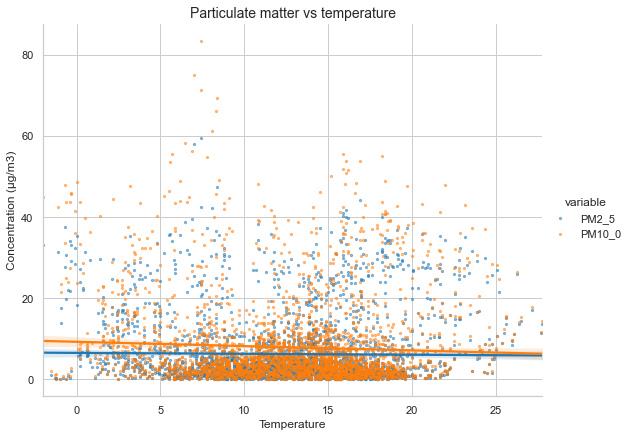

<Figure size 720x576 with 0 Axes>

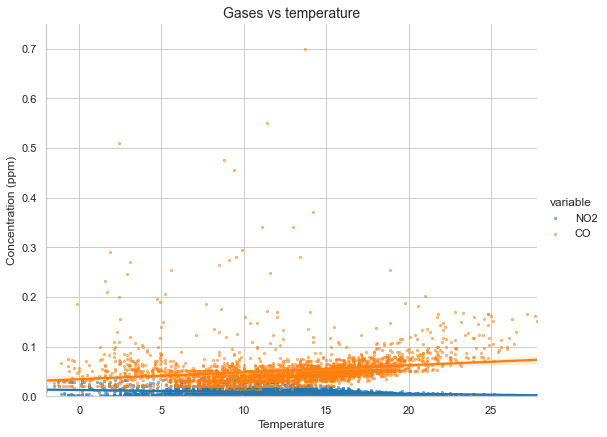

In [11]:
sns.set_style("whitegrid")
sns.set_context("notebook")

long_data = full_data.melt(id_vars=['Temperature', 'Wind_spd', 'Wind_dir'],
                           value_vars=['PM2_5', 'PM10_0', 'NO2', 'CO'])

plt.figure(figsize=(10, 8))
sns.lmplot(data=long_data[long_data.variable.isin(['PM10_0', 'PM2_5'])],
           x='Temperature', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5},
           height=6, aspect=1.3)
plt.title("Particulate matter vs temperature", fontsize=14)
plt.ylabel('Concentration (μg/m3)')

plt.figure(figsize=(10, 8))
sns.lmplot(data=long_data[long_data.variable.isin(['NO2', 'CO'])],
           x='Temperature', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5},
           height=6, aspect=1.3)
plt.title("Gases vs temperature", fontsize=14)
plt.ylabel('Concentration (ppm)')
plt.ylim([0, 0.75])

The particulate matter, CO and NO2 values recorded do not seem to strongly correlate with the temperature.

## Wind speed

<Figure size 720x576 with 0 Axes>

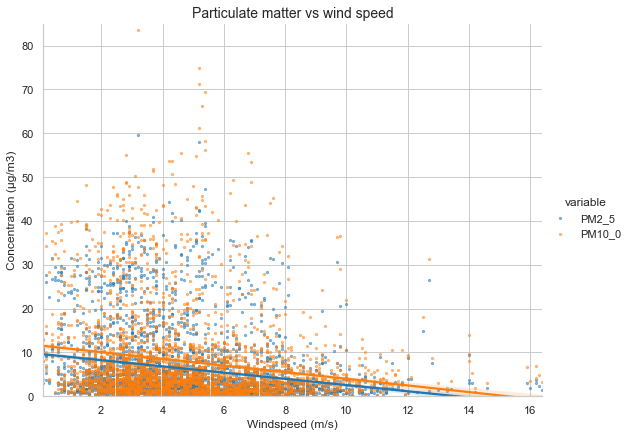

<Figure size 720x576 with 0 Axes>

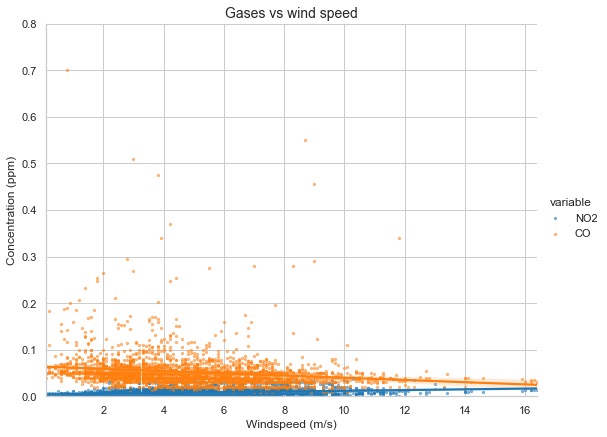

In [16]:
plt.figure(figsize=(10,8))
sns.lmplot(data=long_data[long_data.variable.isin(['PM10_0', 'PM2_5'])],
           x='Wind_spd', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5},
           height=6, aspect=1.3)
plt.ylabel('Concentration (μg/m3)')
plt.ylim([0, 85])
plt.xlabel('Windspeed (m/s)')
plt.title("Particulate matter vs wind speed", fontsize=14)

plt.figure(figsize=(10,8))
sns.lmplot(data=long_data[long_data.variable.isin(['NO2', 'CO'])],
           x='Wind_spd', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5},
           height=6, aspect=1.3)
plt.ylabel('Concentration (ppm)')
plt.ylim([0, 0.8])
plt.xlabel('Windspeed (m/s)')
plt.title("Gases vs wind speed", fontsize=14);

Particulate matter seems to have a weak negative correlation with wind speed. This would make sense, as the pollution is less likely to build up in one area when there is a strong wind.

## Wind direction

<Figure size 720x576 with 0 Axes>

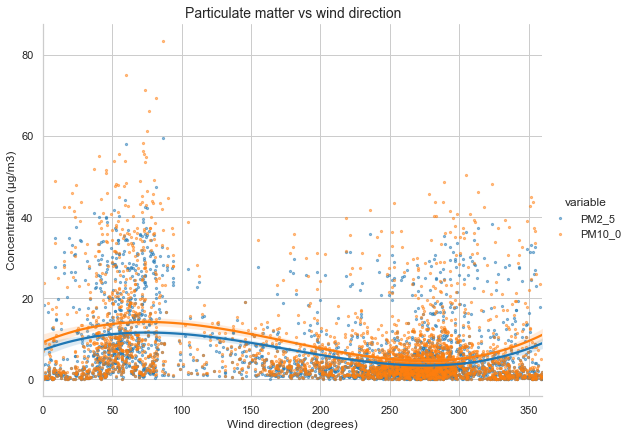

<Figure size 720x576 with 0 Axes>

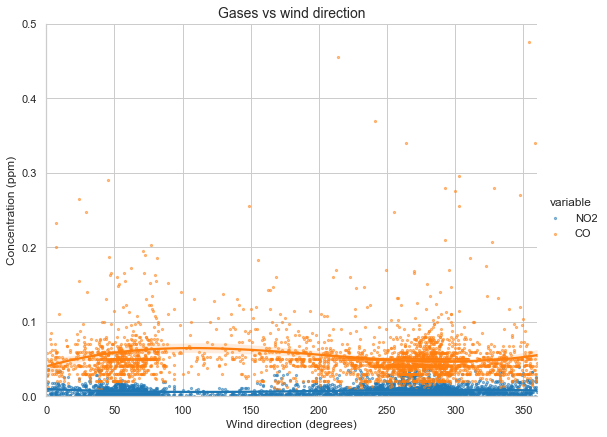

In [19]:
plt.figure(figsize=(10, 8))
sns.lmplot(data=long_data[long_data.variable.isin(['PM10_0', 'PM2_5'])],
           x='Wind_dir', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5},
           order=3, height=6, aspect=1.3)
plt.ylabel('Concentration (μg/m3)')
plt.xlabel("Wind direction (degrees)")
plt.title("Particulate matter vs wind direction", fontsize=14)
plt.xlim(0, 360)

plt.figure(figsize=(10, 8))
sns.lmplot(data=long_data[long_data.variable.isin(['NO2', 'CO'])],
           x='Wind_dir', y='value', hue='variable', scatter_kws={'s':5, 'alpha':0.5},
           order=3, height=6, aspect=1.3)
plt.ylabel('Concentration (ppm)')
plt.ylim([0,0.5])
plt.xlabel("Wind direction (degrees)")
plt.title("Gases vs wind direction", fontsize=14)
plt.xlim(0, 360);

The wind direction seems to affect the particulate matter levels slightly, with particulate matter levels tending to be higher when wind is coming from the North-East or East. This can be visualised more easily on a radial compass diagram.

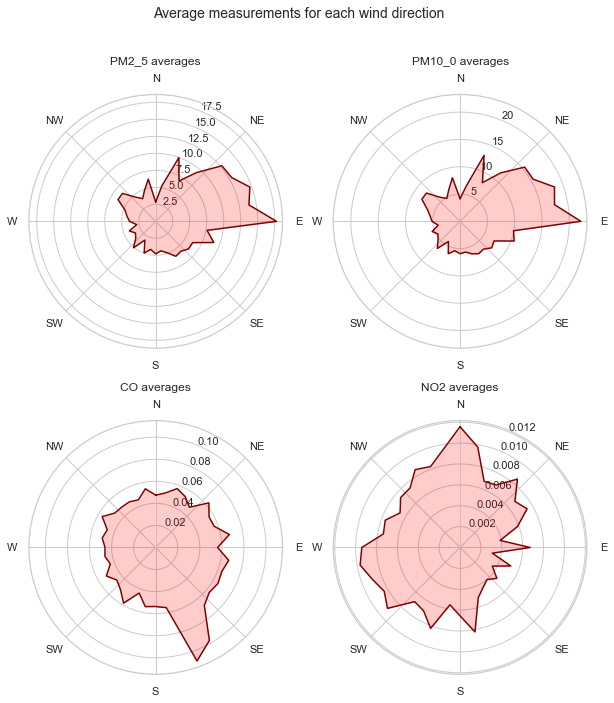

In [20]:
from math import radians

full_data['Wind_dir_round'] = full_data['Wind_dir'].round(-1)
averages_for_wind_dir = full_data.groupby('Wind_dir_round').mean()
#0 and 360 degrees refer to the same direction, so should be the same
averages_for_wind_dir.loc[0] = (averages_for_wind_dir.loc[0] + averages_for_wind_dir.loc[360]) / 2
averages_for_wind_dir.loc[360] = averages_for_wind_dir.loc[0]

f = plt.figure(figsize=(10,11))
f.tight_layout()
f.suptitle("Average measurements for each wind direction", fontsize=14)

variables = ['PM2_5', 'PM10_0', 'CO', 'NO2']

for i in range(4):
    ax = f.add_subplot(221+i, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    ax.plot([radians(x) for x in averages_for_wind_dir.index.values], 
    averages_for_wind_dir[variables[i]].values, color='maroon')
    ax.title.set_text(variables[i]+' averages\n')
    plt.fill_between([radians(x) for x in averages_for_wind_dir.index.values],
                     averages_for_wind_dir[variables[i]].values, 0,
                     facecolor="red", alpha=0.2)